Import all necessary packages and functions

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

We will be looking into BERT deep learning model.

In [2]:
df = pd.read_csv("full_df.csv")

print(df.head())

                                                body  \
0  Subject: naturally irresistible your corporate...   
1  Subject: the stock trading gunslinger  fanny i...   
2  Subject: unbelievable new homes made easy  im ...   
3  Subject: 4 color printing special  request add...   
4  Subject: do not have money , get software cds ...   

                                        cleaned_body  label  \
0  naturally irresistible your corporate identity...      1   
1  the stock trading gunslinger fanny is merrill ...      1   
2  unbelievable new homes made easy im wanting to...      1   
3  color printing special request additional info...      1   
4  do not have money get software cds from here s...      1   

                                            pos_tags  percentage_vb_dt_nn  \
0  ['RB', 'JJ', 'PRP$', 'JJ', 'NN', 'NN', 'VBZ', ...             3.743316   
1  ['DT', 'NN', 'NN', 'NN', 'NN', 'VBZ', 'RB', 'C...             0.000000   
2  ['JJ', 'JJ', 'NNS', 'VBN', 'JJ', 'JJ', 'VBG', ... 

In [19]:
df['text'] = df['tokens'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_words = 20000
max_len = 200

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

X_train_pad, X_val_pad, y_train, y_val = train_test_split(X_train_pad, y_train, test_size=0.2, random_state=42)

df['text']

0         ['naturally', 'irresistible', 'corporate', 'id...
1         ['stock', 'trading', 'gunslinger', 'fanny', 'm...
2         ['unbelievable', 'new', 'home', 'made', 'easy'...
3         ['color', 'printing', 'special', 'request', 'a...
4         ['money', 'get', 'software', 'cd', 'software',...
                                ...                        
125942    ['paypal', 'sent', 'payment', 'usd', 'ftx', 'm...
125943    ['monkeyorg', 'hi', 'josepassword', 'josemonke...
125944    ['hello', 'please', 'note', 'monthly', 'paymen...
125945    ['verify', 'metamask', 'wallet', 'system', 'sh...
125946    ['announcing', 'jotform', 'table', 'spreadshee...
Name: text, Length: 125947, dtype: object

In [29]:
def create_model(optimizer='adam', lstm_units=64, dropout_rate=0.2, embedding_dim=100):
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=X_train_pad.shape[1]))
    model.add(LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

optimizer = 'adam'
lstm_units = 32
dropout_rate = 0.2
embedding_dim = 100
batch_size = 256
epochs = 5
model = create_model(optimizer=optimizer, lstm_units=lstm_units, dropout_rate=dropout_rate, embedding_dim=embedding_dim)

In [30]:
history = model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_pad, y_val))

Epoch 1/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - accuracy: 0.7228 - loss: 0.5093 - val_accuracy: 0.9164 - val_loss: 0.2858
Epoch 2/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - accuracy: 0.9139 - loss: 0.2892 - val_accuracy: 0.9130 - val_loss: 0.2842
Epoch 3/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 79s 251ms/step - accuracy: 0.9157 - loss: 0.2792 - val_accuracy: 0.9250 - val_loss: 0.2559
Epoch 4/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 80s 254ms/step - accuracy: 0.9202 - loss: 0.2665 - val_accuracy: 0.9272 - val_loss: 0.2123
Epoch 5/5
315/315 ━━━━━━━━━━━━━━━━━━━━ 103s 328ms/step - accuracy: 0.9414 - loss: 0.1787 - val_accuracy: 0.9590 - val_loss: 0.1453


788/788 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     13307
           1       0.93      0.98      0.96     11883

    accuracy                           0.96     25190
   macro avg       0.96      0.96      0.96     25190
weighted avg       0.96      0.96      0.96     25190

AUC Score: 0.9725


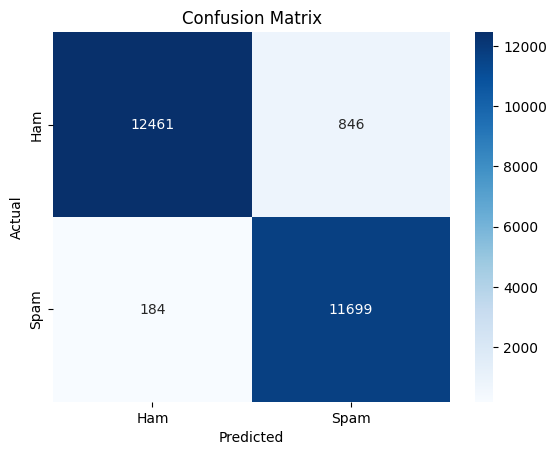

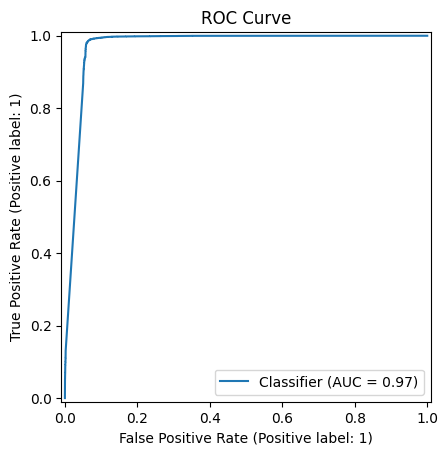

In [32]:
y_pred_prob = model.predict(X_test_pad).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc:.4f}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix", loc='center')
plt.show()

RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve", loc='center')
plt.show()